- RNN-GAN - fourier-transformed audiodata - absolute number values

In [1]:
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.callbacks as call
import tensorflow as tf
import pandas as pd
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import keras
from keras.datasets.mnist import load_data
from keras.utils.vis_utils import plot_model
import IPython

2022-11-30 22:48:01.490304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Add path to util-functions

In [2]:
import sys
import os

from pprint import pprint
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"


sys.path.append("../../../..")
pprint(sys.path)

['/home/jberry/JJBerry/birdvoice-main/gan/rnn/ft/abs',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/home/jberry/.local/lib/python3.8/site-packages',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '../../../..']


The Paths to the FT-databases

In [3]:
databasePathsParusMajor=['../../../../dataPreprocessing/databases/ft/parusMajor/ParusMajorSongFT1.csv', '../../../../dataPreprocessing/databases/ft/parusMajor/ParusMajorSongFT5.csv']
databasePathsTurdusMerula=['../../../../dataPreprocessing/databases/ft/TurdusMerula/TurdusMerulaSongFT5.csv','JJBerry/birdvoice-main/dataPreprocessing/databases/ft/TurdusMerula']
databasePathsCorvusCorone=['../../../../dataPreprocessing/databases/ft/corvusCorone/CorvusCoroneCallFT5.csv']

Load data from chosen path

In [4]:
with tf.device('/gpu:0'):
    readSampleCount = 500

# number of columns per dataset-sample for

# Audios
    ONE_SECOND = 22
    FIVE_SECONDS = 108
    
# MNIST data 
    data_size = 28

#load and reshape data
    x_train = pd.read_csv(databasePathsTurdusMerula[0], header=None, delimiter=',', index_col=None, nrows=readSampleCount).to_numpy()
    print(x_train.shape)
    x_train = np.reshape(x_train, [readSampleCount, 1025, FIVE_SECONDS])
    print(x_train.shape)

#parse to complex128-datatype
    x_train = x_train.astype('complex128')
#convert complex to absolute values
    x_train = abs(x_train)

    _, AUDIO_ROWS, AUDIO_COLS = x_train.shape
    print(x_train.shape)

(500, 110700)
(500, 1025, 108)
(500, 1025, 108)


In [5]:
from librosa import display

def plot_spectogram(Y, sr, hop_length, y_axis = "linear"):
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(Y,
                            sr=sr,
                            hop_length = hop_length,
                            y_axis = y_axis,
                            x_axis = "time")
    plt.colorbar(format="%+2.f")

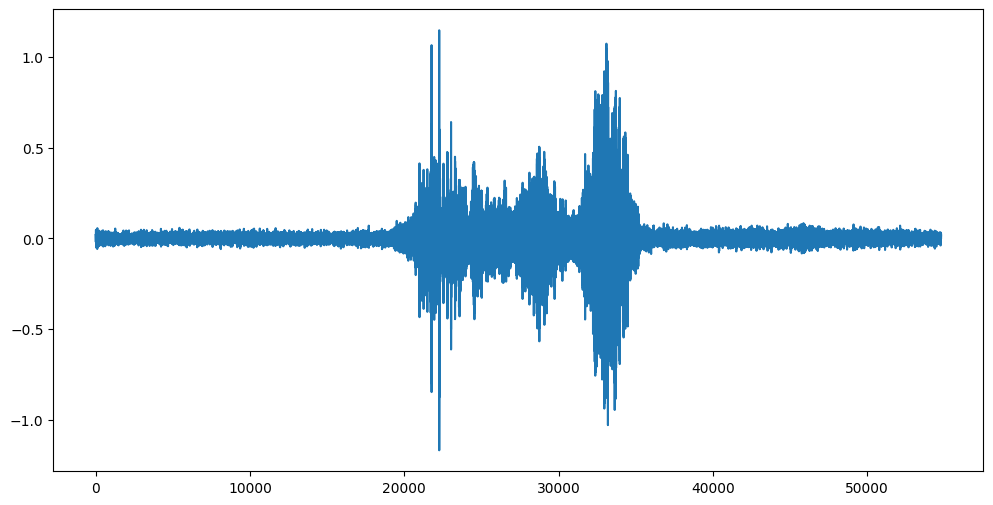

In [6]:
from IPython import display as ipd

istft_test_file = 'test_tm5g4d1gen.wav'
specAudioFileGL = "test_tm5g4d1gl.wav"
specAudioFileSTFT = "test_tm5g4d1gen.wav"



# Abspeichern der Audio Dateien
for x in range(3):
    istftAudio = librosa.istft(x_train[x])
    sf.write('test_tm5g4d1gen'+str(x)+'.wav', istftAudio*100, 11025)

    
istftAudio = librosa.istft(x_train[0])
sf.write(istft_test_file, istftAudio*100, 11025)    
log_glAudio, sr = librosa.load(specAudioFileGL)

# Audio Visualisierung

plt.figure(figsize=(12, 6))
plt.plot(istftAudio*100)

log_istftAudio = librosa.power_to_db(istftAudio*100)
#plot_spectogram(Y = log_istftAudio, sr = sr, hop_length = FIVE_SECONDS)

# Audio Test Ausgabe
ipd.Audio(filename = istft_test_file, 
          rate = 11025)

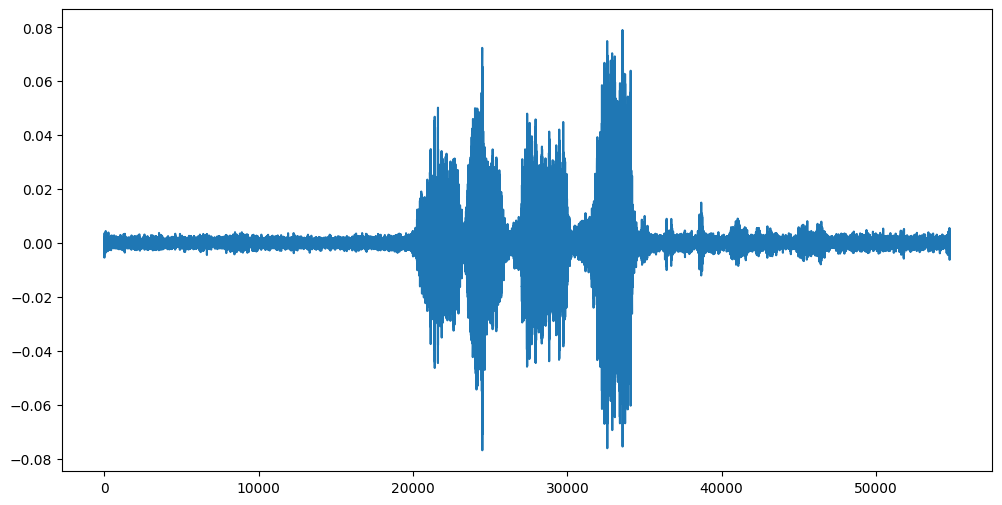

In [7]:
gl_test_file = 'test_tm5g4d1gl.wav'

for x in range(3):
    glAudio = librosa.griffinlim(x_train[x])
    sf.write('test_tm5g4d1gl'+str(x)+'.wav', glAudio*100, 11025)

glAudio = librosa.griffinlim(x_train[0])
sf.write(gl_test_file, glAudio*100, 11025)
# Audio Visualisierung

plt.figure(figsize=(12, 6))
plt.plot(glAudio)

log_glAudio = librosa.power_to_db(glAudio)
#plot_spectogram(Y = log_glAudio, sr = sr, hop_length = FIVE_SECONDS)

# Audio Test Ausgabe
ipd.Audio(filename = gl_test_file, rate = 11025)

Create optimizer

In [8]:
optimiser = keras.optimizers.Adamax(0.0002, 0.75)
optimiserDiscriminator = keras.optimizers.Adamax(0.001, 0.5)

Create the discriminator

In [9]:
from utils.discriminatorsFT import *

In [10]:
with tf.device('/gpu:0'):
    discriminator = buildDiscriminator1(AUDIO_ROWS, AUDIO_COLS)
    discriminator.compile(loss = "binary_crossentropy",
                      optimizer = optimiserDiscriminator,
                      metrics = [keras.metrics.Accuracy()])
    discriminator.summary()

    print(discriminator.metrics)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1025, 512)         55808     
                                                                 
 dense_1 (Dense)             (None, 1025, 256)         131328    
                                                                 
 dense_2 (Dense)             (None, 1025, 108)         27756     
                                                                 
Total params: 214,892
Trainable params: 214,892
Non-trainable params: 0
_________________________________________________________________
[]


In [11]:
with tf.device('/gpu:0'):
    discriminator2 = buildDiscriminator2(data_size, data_size)
    discriminator2.compile(loss = "binary_crossentropy",
                      optimizer = optimiserDiscriminator,
                      metrics = [keras.metrics.Accuracy()])
    discriminator2.summary()

    print(discriminator2.metrics)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 28, 512)           14848     
                                                                 
 lstm (LSTM)                 (None, 28, 256)           787456    
                                                                 
 dense_4 (Dense)             (None, 28, 28)            7196      
                                                                 
Total params: 809,500
Trainable params: 809,500
Non-trainable params: 0
_________________________________________________________________
[]


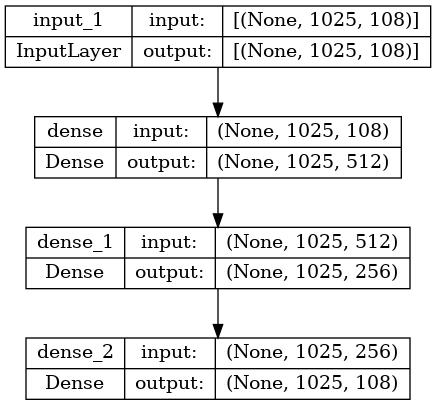

In [12]:
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)


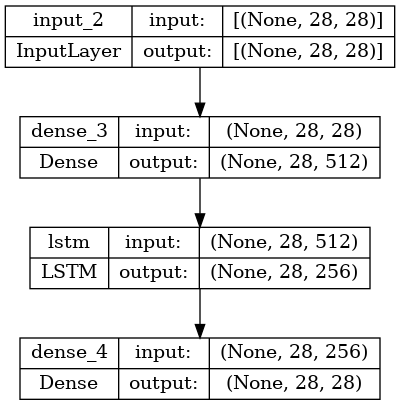

In [13]:
plot_model(discriminator2, to_file='discriminator2_plot.png', show_shapes=True, show_layer_names=True)

Create the generator and GAN

In [14]:
from utils.generatorsFT import *

In [34]:
with tf.device('/gpu:0'):
    generator = buildGenerator4(data_size, data_size)
    gan = keras.models.Sequential( [generator, discriminator] )
    gan.compile(loss="binary_crossentropy",
           optimizer = optimiser,
           metrics = [keras.metrics.Accuracy()])
    print(gan.metrics)
    print(f"Generator Trainable: {generator.trainable}")
    print(f"GAN Trainable: {gan.trainable}")


[]
Generator Trainable: True
GAN Trainable: True


with tf.device('/gpu:0'):
    generator2 = buildGenerator5(AUDIO_ROWS, AUDIO_COLS, latent_dim=10)
    gan2 = keras.models.Sequential( [generator2, discriminator2] )
    gan2.compile(loss="binary_crossentropy",
           optimizer = optimiser,
           metrics = [keras.metrics.Accuracy()])
    print(gan2.metrics)
    print(f"Generator Trainable: {generator2.trainable}")
    print(f"GAN Trainable: {gan2.trainable}")


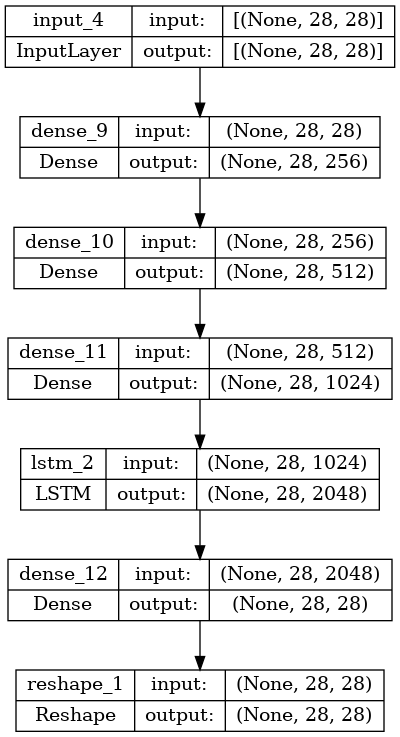

In [35]:
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Run the training:

In [36]:
from utils.trainingFT import *
from utils.trainingFT2 import *
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint

In [37]:
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    print(ix)
    print()
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, data_size, data_size))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(n_samples, latent_dim):
    # generate points in the latent space
    print(n_samples)
    print(latent_dim)
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, data_size, data_size)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points( n_samples, latent_dim)
    print(f"X_INPUT: {x_input}")
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, data_size, data_size))
    return X, y

In [38]:
from keras.utils.vis_utils import plot_model
from numpy import vstack

n_samples = 50
n_halfBatch = int(n_samples/2)

(trainX, trainy), (testX, testy) = load_data()
latent_dim = int(data_size * data_size)
X_fake, y_fake = generate_fake_samples(generator, latent_dim, n_halfBatch)
X_real, y_real = generate_real_samples(trainX, n_halfBatch)

print(X_fake)
print(y_fake)

print(X_real)
print(y_real)

X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))


ITERATIONS = 128
BATCH_SIZE = 8
print(discriminator.trainable)
print(gan.layers)

#with tf.device('/gpu:0'):
    #trainFT(iterations=ITERATIONS, 
    #        batch_size=BATCH_SIZE, 
    #        generator=generator, 
    #        discriminator=discriminator, 
    #        network=gan, 
    #        data=x_train, 
    #        columnCount=AUDIO_COLS, 
    #        discriminatorOptimizer = optimiserDiscriminator, 
    #        Optimizer = optimiser)
    
    
    # g_metrics = trainGAN(gan = gan,
    #                      generator = generator,
    #                      discriminator = discriminator,
    #                      Iterations = ITERATIONS,
    #                      BatchSize = BATCH_SIZE,
    #                     x_train = x_train )

#print("Generator:")
#generator.summary()
#print("Discriminator:")
#discriminator.summary()
#print("GAN:")
#gan.summary()


25
784
X_INPUT: [[[-0.42871025 -0.38826915 -0.73807958 ...  0.39704964 -0.44789167
   -0.35277806]
  [-1.98046065 -1.90412559 -1.46087229 ...  3.11677206 -0.13493428
   -1.12352439]
  [ 1.0115032   0.98103468 -1.27986712 ...  0.54846309 -0.94931373
   -1.62458362]
  ...
  [ 1.21952375  2.38666004 -1.64878777 ...  0.60500032  0.42915693
    1.04988784]
  [ 0.36910733 -0.18459135 -0.31371956 ...  0.32542379 -0.21957537
   -2.16944975]
  [ 0.01579055 -0.00647786 -1.14699685 ... -0.03455519 -0.08414071
    3.02385097]]

 [[ 1.35152337 -0.21103939 -1.35185956 ...  0.86070433  0.26241099
   -0.49241472]
  [-1.31789413 -1.79256063 -1.66249733 ... -0.63203522 -1.51932432
   -0.53543822]
  [ 0.22998391 -0.47597592  0.92571235 ... -0.60236582  0.61342085
   -0.72678302]
  ...
  [ 0.17942593  0.43684719 -1.17307571 ... -0.22003964  0.10693158
    0.02422241]
  [-0.29502169 -1.89673183  1.64678646 ... -1.16191514 -0.86001841
    0.87888435]
  [-0.98595098  0.23747927 -0.57825781 ... -1.26234413 -1

from keras import Model as model

print(d_loss_real)
print(generator.layers)
history = model.fit(x_train, generator.history, epochs=ITERATIONS, batch_size=BATCH_SIZE)
print(history.history)
plt.plot(generator.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Test of generator after training

1/1 [==============================] - 0s 186ms/step
(8, 28, 28)
50
784
X_INPUT: [[[-1.14652493e-02 -1.76851443e+00  1.10210665e-01 ... -1.55162563e+00
   -3.07372310e-01  1.10599564e+00]
  [ 7.26064000e-01  9.49778007e-01 -1.68292567e-01 ...  7.61913787e-01
    3.90695787e-01  1.41913623e+00]
  [ 9.78375360e-01  2.36398889e-01  2.36114721e-02 ...  4.30499479e-01
   -3.57802317e-01 -5.48190618e-01]
  ...
  [-7.67818279e-01 -1.52923779e+00 -2.11931784e-01 ... -6.65881088e-01
    2.94433949e-01 -1.00503126e+00]
  [ 9.58224611e-01  1.50816884e+00 -1.37255431e+00 ...  1.57054262e+00
   -1.03576182e-02  7.02975152e-01]
  [-3.78900523e-01 -4.44822533e-01  3.43142752e-01 ...  4.67879302e-01
   -1.00778338e+00  5.47654328e-01]]

 [[ 7.08961363e-01 -6.91841263e-01 -1.53386251e+00 ... -7.10048709e-01
    2.37755744e-01  1.05404825e-01]
  [ 2.33473047e-01 -3.51998615e-01 -1.68084881e+00 ... -8.68227031e-01
   -2.47019956e-01 -1.46274718e-01]
  [-6.35947613e-01  6.74780057e-02  3.58430371e-01 ... 

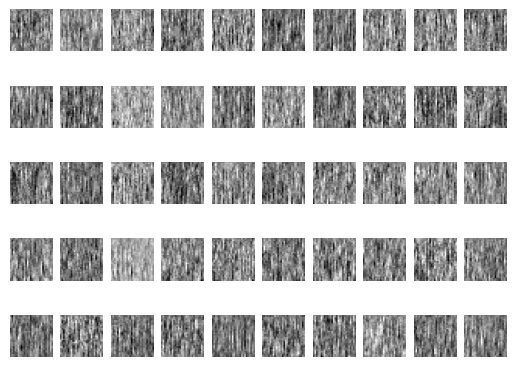

In [41]:
#generate sound
#noise = np.random.normal(0,0.5, (1, 1025, AUDIO_COLS))
noise2 = np.random.normal(0,0.5,(BATCH_SIZE, 28, 28))
#fake_audios = generator.predict(noise)
fake_images = generator.predict(noise2)
print(fake_images.shape)

istftAudio = librosa.istft(fake_audios[0])
glAudio = librosa.griffinlim(fake_audios[0])

# plot the generated samples
X, _ = generate_fake_samples(generator, latent_dim, n_samples)
for i in range(n_samples):
    print(f"FOR ITERATION CYCLE: {i} of {n_samples}")
    # define subplot
    plt.subplot(5, 10, 1 + i)
    # turn off axis labels
    plt.axis('off')
    # plot single image
    plt.imshow(X[i, :, :], cmap='gray_r')
# show the figure
plt.show()

#show
#plt.figure(figsize=(12, 6))
#plt.plot(istftAudio*100)



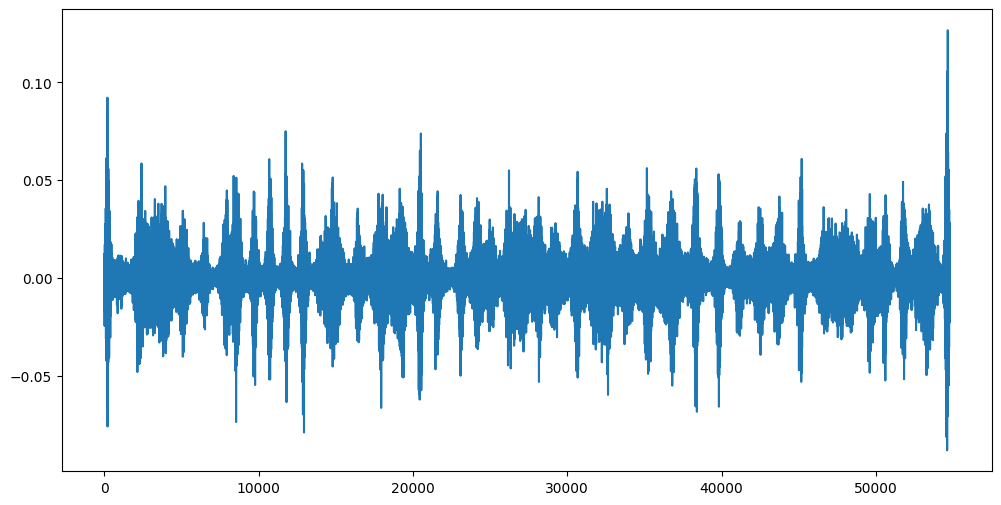

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(glAudio)

ipd.Audio(data = glAudio, rate = 11025)

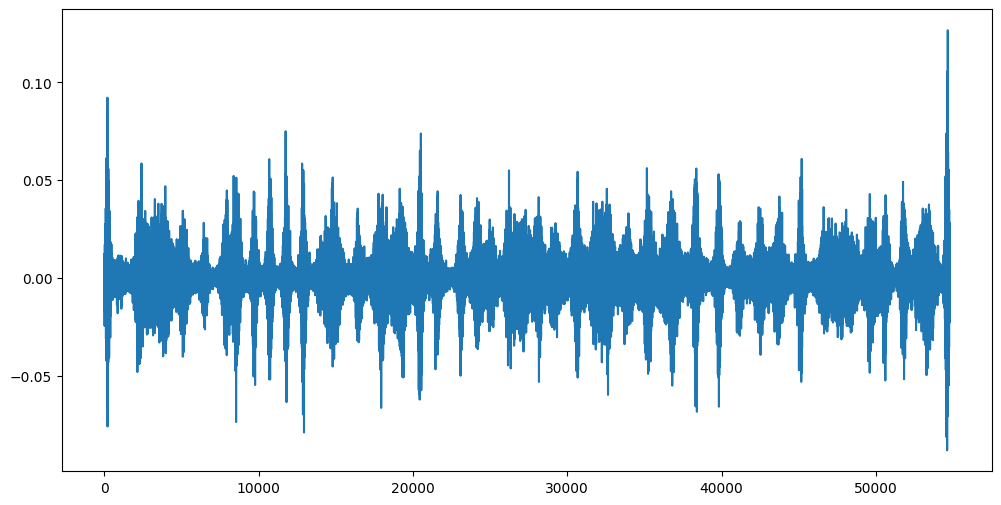

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(glAudio)

ipd.Audio(data = istftAudio, rate = 11025)

Save generated output to file

In [23]:
sf.write("tm5g4d1gen.wav", istftAudio*100, 11025)
sf.write("tm5g4d1gl.wav", glAudio, 11025)

In [24]:

specAudioFileGL = "tm5g4d1gl.wav"
specAudioFileSTFT = "tm5g4d1gen.wav"

specAudioGL, sr = librosa.load(specAudioFileGL)
specAudioSTFT, _ = librosa.load(specAudioFileSTFT)

S_GL = librosa.stft(specAudioGL, n_fft=2048, hop_length=204)
S_STFT = librosa.stft(specAudioSTFT, n_fft=2048, hop_length=204)


print(S_GL.shape)
print(sr)

S_STFT.shape
print(type(specAudioGL))
print(specAudioGL.shape)
ipd.Audio(data = istftAudio*100, rate = 11025)

(1025, 538)
22050
<class 'numpy.ndarray'>
(109568,)


/home/jberry/.local/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


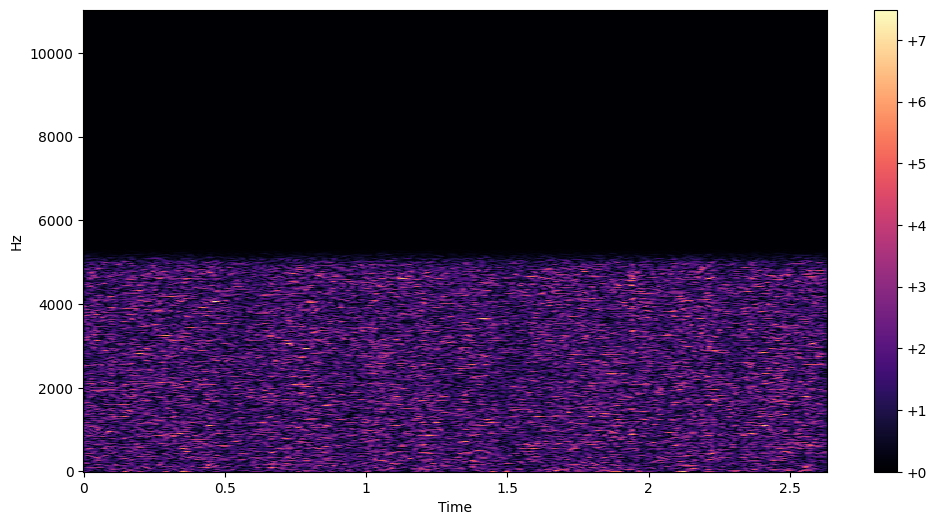

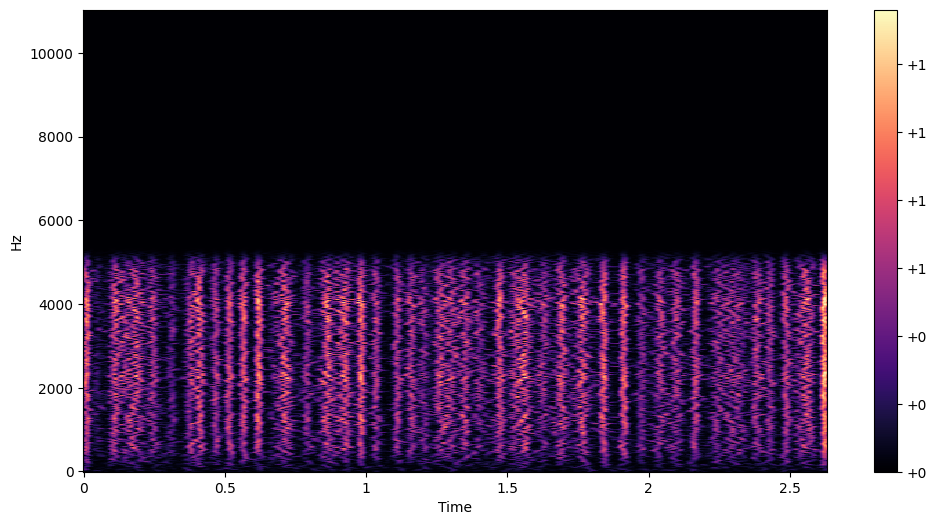

In [25]:
from scipy import signal
from scipy.fft import fftshift

plot_spectogram(Y = S_STFT, sr = sr, hop_length = FIVE_SECONDS)
plot_spectogram(Y = S_GL, sr = sr, hop_length = FIVE_SECONDS)

/home/jberry/.local/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  return f(*args, **kwargs)


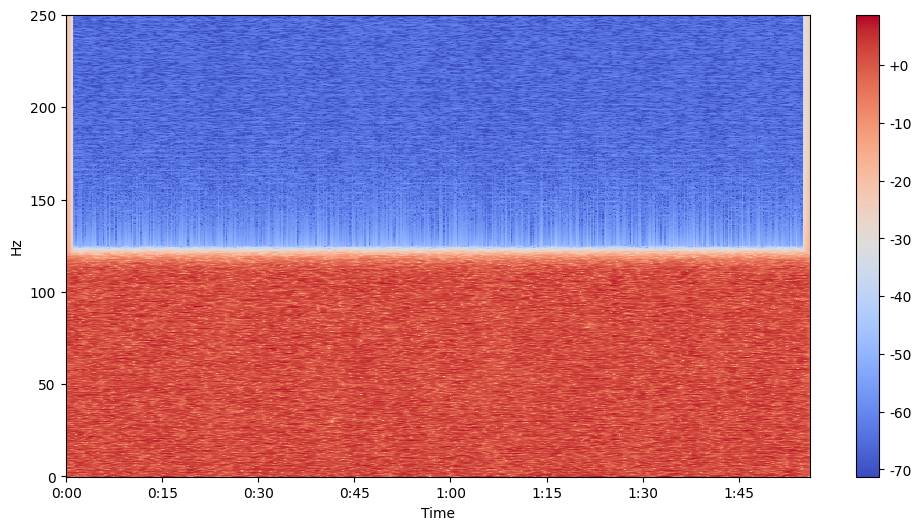

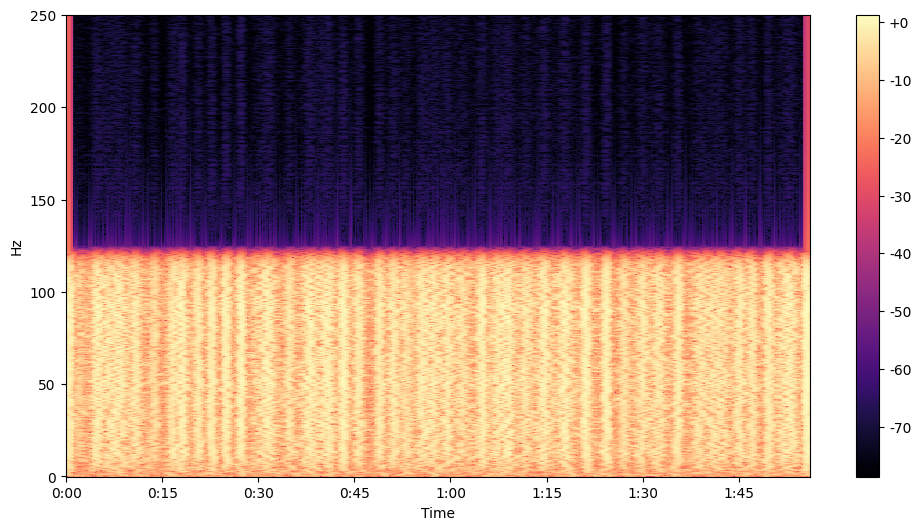

In [26]:
log_specAudio = librosa.power_to_db(S_STFT)
plot_spectogram(log_specAudio, readSampleCount, FIVE_SECONDS)
log_specAudio = librosa.power_to_db(S_GL)
plot_spectogram(log_specAudio, readSampleCount, FIVE_SECONDS)

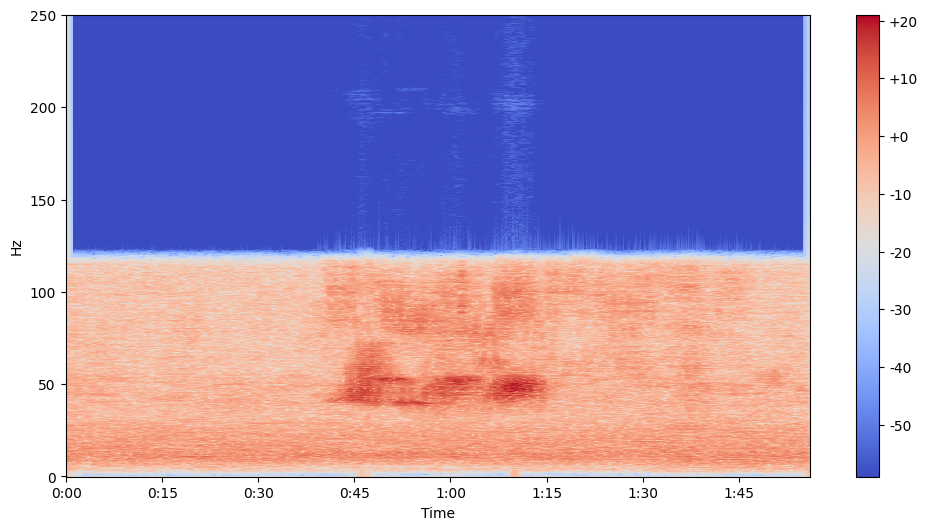

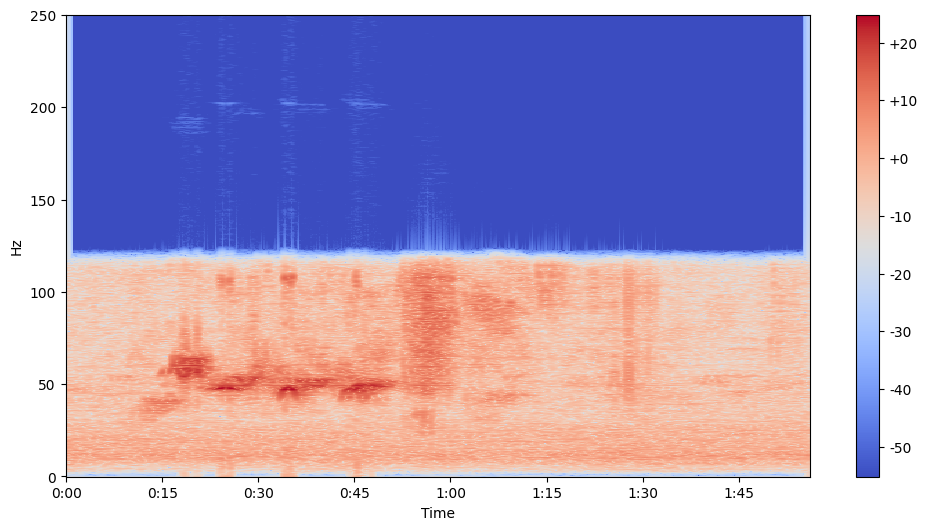

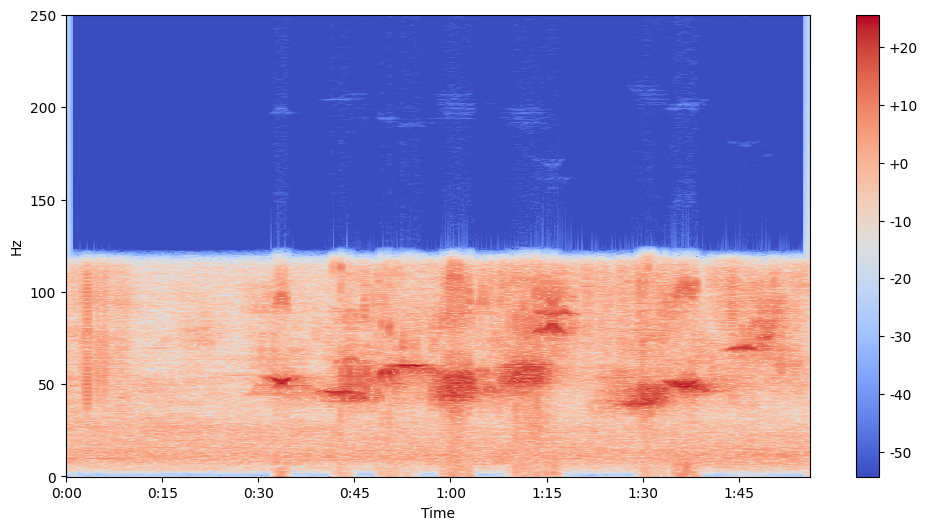

In [27]:


for x in range(3):
    specAudioFileSTFT = 'test_tm5g4d1gen'+str(x)+'.wav'
    specAudioSTFT, _ = librosa.load(specAudioFileSTFT)
    S_STFT = librosa.stft(specAudioSTFT, n_fft=2048, hop_length=204)
    log_specAudio = librosa.power_to_db(S_STFT)
    plot_spectogram(log_specAudio, readSampleCount, FIVE_SECONDS)

/home/jberry/.local/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=702
  return f(*args, **kwargs)


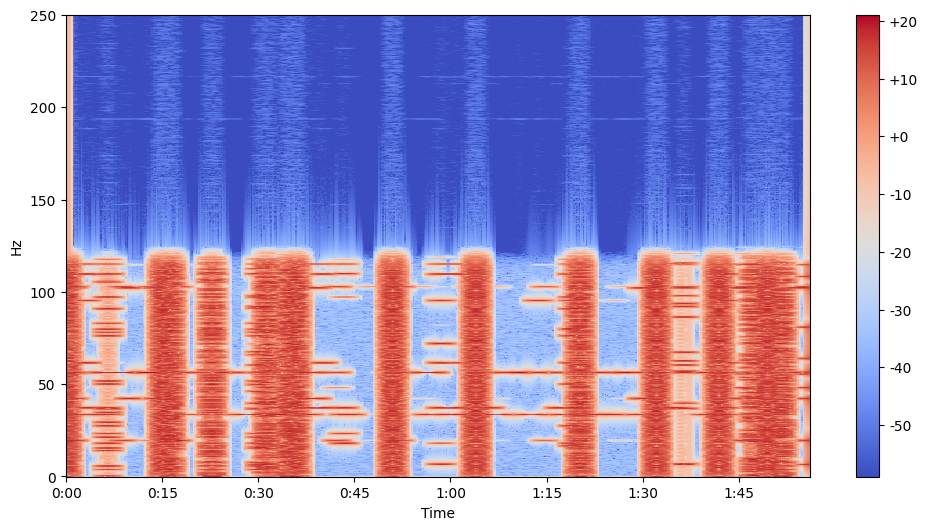

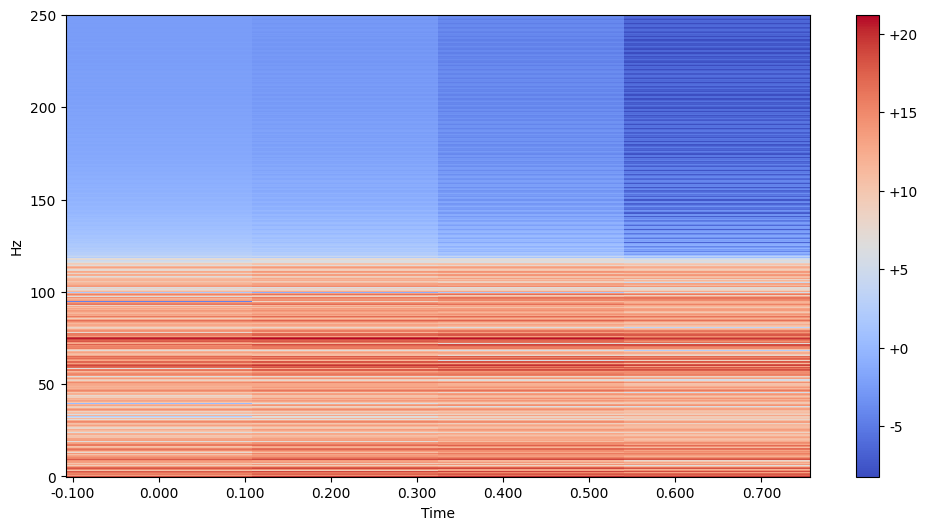

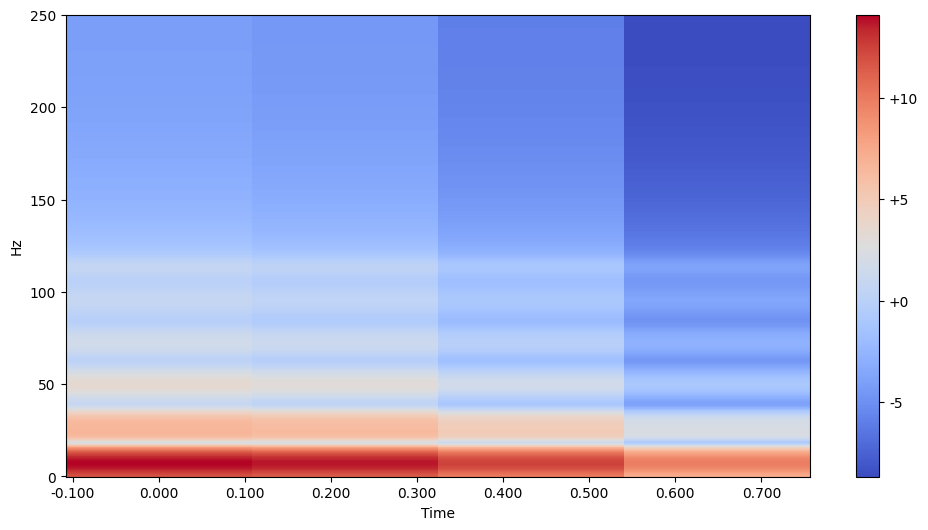

In [28]:

specAudioFileSTFTArr = ['tm5g4d1gen-test-istft_11-02-2022-09_20.wav', 'tm5g4d1gen-test-istft_11-02-2022-07_44.wav', 'tm5g4d1gen-test-istft_11-02-2022-07_12.wav']
for x in range(len(specAudioFileSTFTArr)):
    specAudioFileSTFT = specAudioFileSTFTArr[x]
    specAudioSTFT, _ = librosa.load(specAudioFileSTFT)
    S_STFT = librosa.stft(specAudioSTFT, n_fft=2048, hop_length=204)
    log_specAudio = librosa.power_to_db(S_STFT)
    plot_spectogram(log_specAudio, readSampleCount, FIVE_SECONDS)